# Working with highly imbalanced data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.rcParams["figure.dpi"] = 200
np.set_printoptions(precision=3, suppress=True)
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale, StandardScaler

In [2]:
rng = np.random.RandomState(0)
n_samples_1 = 1000
n_samples_2 = 100
X_syn = np.r_[1.5 * rng.randn(n_samples_1, 2),
        0.5 * rng.randn(n_samples_2, 2) + [2, 2]]
y_syn = np.array([0] * (n_samples_1) + [1] * (n_samples_2))
X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn)

In [3]:
# mammography dataset https://www.openml.org/d/310
data = pd.read_csv("https://www.openml.org/data/v1/get_csv/52214")

In [4]:
target = data['class']

In [5]:
target.value_counts()

'-1'    10923
'1'       260
Name: class, dtype: int64

In [6]:
y = (target == "'-1'").astype(np.int)

In [7]:
X = data.iloc[:, :-1]
X.shape

(11183, 6)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb68ec58198>,
      dtype=object)

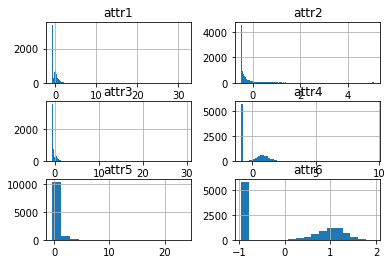

In [8]:
X.hist(bins='auto')

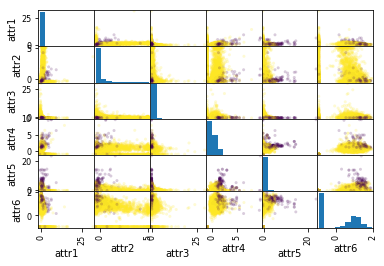

In [9]:
pd.plotting.scatter_matrix(X, c=y, alpha=.2);

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, stratify=y, random_state=0)

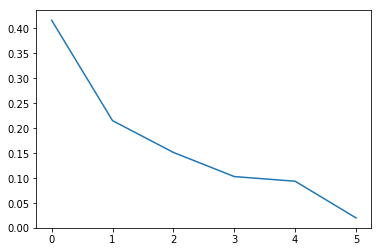

In [11]:
from sklearn.decomposition import PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
plt.plot(pca.explained_variance_ratio_)

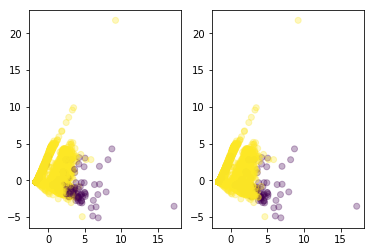

In [12]:
sorting = np.argsort(y_train)
fig, axes = plt.subplots(1, 2)
axes[0].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train[:], alpha=.3)
axes[1].scatter(X_train_pca[sorting, 0], X_train_pca[sorting, 1], c=y_train[sorting], alpha=.3)

In [13]:
from sklearn.preprocessing import RobustScaler
rs = RobustScaler().fit(X_train)
X_train_scaled = rs.transform(X_train)

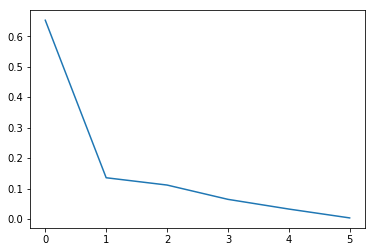

In [14]:
pca_scaled = PCA()
X_train_pca_scaled = pca_scaled.fit_transform(X_train_scaled)
plt.plot(pca_scaled.explained_variance_ratio_)

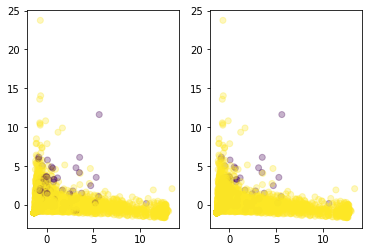

In [15]:
fig, axes = plt.subplots(1, 2)
axes[0].scatter(X_train_pca_scaled[:, 0], X_train_pca_scaled[:, 1], c=y_train[:], alpha=.3)
axes[1].scatter(X_train_pca_scaled[sorting, 0], X_train_pca_scaled[sorting, 1], c=y_train[sorting], alpha=.3)

Text(0.5,1,'Feature 3 vs 4 sorted')

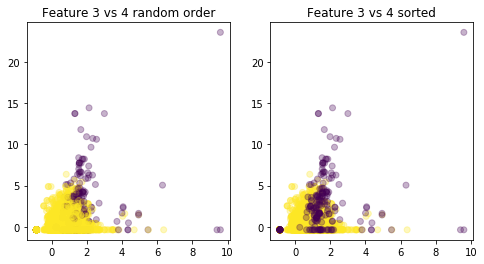

In [18]:
sorting = np.argsort(y_train)[::-1]
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].scatter(X_train[:, 3], X_train[:, 4], c=y_train[:], alpha=.3)
axes[1].scatter(X_train[sorting, 3], X_train[sorting, 4], c=y_train[sorting], alpha=.3)
axes[0].set_title("Feature 3 vs 4 random order")
axes[1].set_title("Feature 3 vs 4 sorted")

In [ ]:
from sklearn.linear_model import LogisticRegression
scores = cross_val_score(LogisticRegression(),
                         X_train, y_train, cv=10, scoring='roc_auc')
print(scores.mean())

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
scores = cross_val_score(LogisticRegressionCV(scoring='roc_auc'), X_train, y_train, cv=10, scoring='roc_auc')
print(scores.mean())

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(replacement=False)
X_train_subsample, y_train_subsample = rus.fit_sample(X_train, y_train)
print(X_train.shape)
print(X_train_subsample.shape)
print(np.bincount(y_train_subsample))

In [ ]:
from imblearn.pipeline import make_pipeline as make_imb_pipeline

undersample_pipe = make_imb_pipeline(RandomUnderSampler(), LogisticRegressionCV())
scores = cross_val_score(undersample_pipe, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_train_oversample, y_train_oversample = ros.fit_sample(X_train, y_train)
print(X_train.shape)
print(X_train_oversample.shape)
print(np.bincount(y_train_oversample))

In [ ]:
oversample_pipe = make_imb_pipeline(RandomOverSampler(), LogisticRegression())
scores = cross_val_score(oversample_pipe, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

In [ ]:
scores = cross_val_score(LogisticRegression(class_weight='balanced'),
                                            X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

In [ ]:
from sklearn.metrics import roc_curve
oversample_pipe.fit(X_train, y_train)
props_oversample = oversample_pipe.predict_proba(X_test)[:, 1]
fpr_over, tpr_over, _ = roc_curve(y_test, props_oversample)

undersample_pipe.fit(X_train, y_train)
props_undersample = undersample_pipe.predict_proba(X_test)[:, 1]
fpr_under, tpr_under, _ = roc_curve(y_test, props_undersample)

lr = LogisticRegression().fit(X_train, y_train)
props_original = lr.predict_proba(X_test)[:, 1]
fpr_org, tpr_org, _ = roc_curve(y_test, props_original)

plt.plot(fpr_org, tpr_org, label="original")
plt.plot(fpr_over, tpr_over, label="oversample")
plt.plot(fpr_under, tpr_under, label="undersample")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
scores = cross_val_score(RandomForestClassifier(n_estimators=100),
                         X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

In [ ]:
undersample_pipe_rf = make_imb_pipeline(RandomUnderSampler(), RandomForestClassifier())
scores = cross_val_score(undersample_pipe_rf, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

In [ ]:
oversample_pipe_rf = make_imb_pipeline(RandomOverSampler(), RandomForestClassifier())
scores = cross_val_score(oversample_pipe_rf, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

In [ ]:
from sklearn.metrics import roc_curve
oversample_pipe_rf.fit(X_train, y_train)
props_oversample = oversample_pipe_rf.predict_proba(X_test)[:, 1]
fpr_over, tpr_over, _ = roc_curve(y_test, props_oversample)

undersample_pipe_rf.fit(X_train, y_train)
props_undersample = undersample_pipe_rf.predict_proba(X_test)[:, 1]
fpr_under, tpr_under, _ = roc_curve(y_test, props_undersample)

rf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
props_original = rf.predict_proba(X_test)[:, 1]
fpr_org, tpr_org, _ = roc_curve(y_test, props_original)

plt.plot(fpr_org, tpr_org, label="original")
plt.plot(fpr_over, tpr_over, label="oversample")
plt.plot(fpr_under, tpr_under, label="undersample")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("RF comparison")

# Class Weights

In [ ]:
from sklearn.linear_model import LogisticRegression
scores = cross_val_score(LogisticRegression(class_weight='balanced'),
                         X_train, y_train, cv=10, scoring='roc_auc')
print(scores.mean())

In [ ]:
from sklearn.ensemble import RandomForestClassifier
scores = cross_val_score(RandomForestClassifier(n_estimators=100, class_weight='balanced'),
                         X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

# Resampled Ensembles

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
def make_resample_tree(random_state=0):
    tree = make_imb_pipeline(RandomUnderSampler(random_state=random_state, replacement=True),
                             DecisionTreeClassifier(max_features='auto', random_state=random_state))
    return "tree_{}".format(random_state), tree
classifiers = [make_resample_tree(i) for i in range(100)]
resampled_rf = VotingClassifier(classifiers, voting='soft')

In [ ]:
scores = cross_val_score(resampled_rf, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

In [ ]:
from sklearn.base import clone

def make_resampled_ensemble(estimator, n_estimators=100):
    estimators = []
    for i in range(n_estimators):
        est = clone(estimator)
        if hasattr(est, "random_state"):
            est.random_state = i
        pipe = make_imb_pipeline(RandomUnderSampler(random_state=i, replacement=True),
                                 est)
        estimators.append(("est_{}".format(i), pipe))
    return VotingClassifier(estimators, voting="soft")

In [ ]:
resampled_tree_test = make_resampled_ensemble(DecisionTreeClassifier(max_features='auto'))

scores = cross_val_score(resampled_tree_test, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

In [ ]:
resampled_lr = make_resampled_ensemble(LogisticRegression())

scores = cross_val_score(resampled_lr, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))